#Semi-supervised learning

Semi-supervised learning is a machine learning approach that utilizes both (small-scale) ***labeled*** data and (large-scale) ***unlabeled*** data. A teacher model is first trained with labeled data. Then the trained teacher model predicts the labels of unlabeled data. A student model is optimized to predict both the labels of labeled data and the pseudo-labels (the prediction by teacher) of unlabeled data.

#Knowledge expansion and distillation

The size of the student model is not necessarily smaller than the size of the teacher model. As a student model is exposed with larger-scale data with more difficult environments (noise), it can learn more information than the teacher model. One can interpret this method as ***knowledge expansion***.

On the other hand, we can also reduce the size of the student model for the sake of model compression. This process is called ***knowledge distillation*** and it is suitable for applications with less computing power.

In this example finetuned Huggingface audio classification model is used as a teacher.

[Distill Notebooks](https://github.com/42io/tflite_kws/blob/master/.github/jupyter/distill/)

In [1]:
TFLITE_MODEL_PATH = '/content/gdrive/MyDrive/0-9.distill.s2cnn47.tflite'
TOTAL_TRAINING_EPOCHS = 500

In [2]:
from google.colab import drive
drive.mount(TFLITE_MODEL_PATH[:15])

Mounted at /content/gdrive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from operator import itemgetter
from tqdm.notebook import tqdm
print('TensorFlow', tf.__version__)
print('TensorFlow Datasets', tfds.__version__)
print('Numpy', np.__version__)
!python -V

TensorFlow 2.12.0
TensorFlow Datasets 4.9.2
Numpy 1.24.3
Python 3.10.11


In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
resolver.get_tpu_system_metadata()

TPUSystemMetadata(num_cores=8, num_hosts=1, num_of_cores_per_host=8, topology=None, devices=(_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)))

In [5]:
GLOBAL_BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [6]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(
    self, learning_rate_base, total_steps, warmup_learning_rate, warmup_ratio
  ):
    super().__init__()

    self.learning_rate_base = learning_rate_base
    self.total_steps = total_steps
    self.warmup_learning_rate = warmup_learning_rate
    self.warmup_steps = int(total_steps * warmup_ratio)
    self.pi = tf.constant(np.pi)

  def __call__(self, step):
    if self.total_steps < self.warmup_steps:
      raise ValueError("Total_steps must be larger or equal to warmup_steps.")

    cos_annealed_lr = tf.cos(
      self.pi
      * (tf.cast(step, tf.float32) - self.warmup_steps)
      / float(self.total_steps - self.warmup_steps)
    )
    learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

    if self.warmup_steps > 0:
      if self.learning_rate_base < self.warmup_learning_rate:
        raise ValueError(
          "Learning_rate_base must be larger or equal to "
          "warmup_learning_rate."
        )
      slope = (
        self.learning_rate_base - self.warmup_learning_rate
      ) / self.warmup_steps
      warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
      learning_rate = tf.where(
        step < self.warmup_steps, warmup_rate, learning_rate
      )
    return tf.where(
      step > self.total_steps, 0.0, learning_rate, name="learning_rate"
    )

In [7]:
class Distiller(keras.Model):

  def __init__(self, student):
    super().__init__()
    self.student = student
    self.loss_tracker = keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    metrics = super().metrics
    metrics.append(self.loss_tracker)
    return metrics

  def compile(self, temperature, alpha=0.1, **kwargs):
    super().compile(**kwargs)
    self.alpha = alpha
    self.temperature = temperature

  def train_step(self, data):
    # Unpack data
    x, teacher_predictions = itemgetter('mfcc', 'logits')(data)

    with tf.GradientTape() as tape:
      # Forward pass of student
      student_predictions = self.student(x, training=True)

      # Compute losses
      loss = keras.losses.kld(
        tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
        tf.nn.softmax(student_predictions / self.temperature, axis=1),
      ) * self.temperature**2

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Report progress
    self.loss_tracker.update_state(loss)
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    # Unpack data
    x, teacher_predictions, y = itemgetter('mfcc', 'logits', 'label')(data)

    # Forward passes
    student_predictions = self.student(x, training=False)

    # Compute losses
    loss = keras.losses.kld(
      tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
      tf.nn.softmax(student_predictions / self.temperature, axis=1),
    ) * self.temperature**2

    # Report progress
    self.loss_tracker.update_state(loss)
    self.compiled_metrics.update_state(y, student_predictions)
    return {m.name: m.result() for m in self.metrics}

In [8]:
def spectrogram_masking(spectrogram, dim, masks_number=2, mask_max_size=2):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [9]:
def build_model(num_labels, activation='elu', poolng=keras.layers.MaxPool1D):

  model = keras.Sequential(name='mask' if num_labels == 2 else 'classifier')

  x = x_in = keras.Input(shape=(47, 13))

  x = keras.layers.Dense(128, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.SpatialDropout1D(x.shape[-1] / 5120.0)(x)

  for i in range(4)[::-1]:
    r = keras.layers.Conv1D(4 * x.shape[-1], 3, padding='same', use_bias=False)(x)
    r = keras.layers.BatchNormalization()(r)
    r = keras.layers.Activation(activation)(r)
    r = keras.layers.SpatialDropout1D(r.shape[-1] / 5120.0)(r)
    r = keras.layers.Conv1D(x.shape[-1], 2, padding='same', use_bias=False)(r)
    r = keras.layers.BatchNormalization()(r)
    x = keras.layers.add([r, x])
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.SpatialDropout1D(x.shape[-1] / 5120.0)(x)
    x = poolng(2 if i else x.shape[1], padding='same')(x)

  x = keras.layers.Flatten()(x)
  model.add(keras.Model(inputs=x_in, outputs=x))

  x = x_in = keras.Input(shape=x.shape[-1])
  r = keras.layers.Dense(2 * x.shape[-1], use_bias=False)(x)
  r = keras.layers.BatchNormalization()(r)
  r = keras.layers.Activation(activation)(r)
  r = keras.layers.Dropout(r.shape[-1] / 5120.0)(r)
  r = keras.layers.Dense(x.shape[-1], use_bias=False)(r)
  r = keras.layers.BatchNormalization()(r)
  x = keras.layers.add([r, x])
  x = keras.layers.Activation(activation)(x)
  x = keras.layers.Dropout(x.shape[-1] / 5120.0)(x)

  x = keras.layers.Dense(num_labels)(x)
  model.add(keras.Model(inputs=x_in, outputs=x))
  return model

# Digit 0-9up NN

In [10]:
(extra_dataset,), info = tfds.load(
    name='my_dataset', split=['train'],
    data_dir='gs://tfds-0-9up-ensemble-cv12-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/0-9up_ft_ensemble_distilled_from_cv12_balanced_mfcc'
assert len(extra_dataset) == 2056992, len(extra_dataset)

In [11]:
(train_dataset, test_dataset, valid_dataset), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-0-9up-ensemble-ft-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/0-9up-ft_ensemble_distilled_mfcc'
assert len(train_dataset) == 1095480, len(train_dataset)

In [12]:
# assert [2056969, 1095477, 3773, 3368] == [
#     len(set(hash(d['mfcc'].numpy().tobytes()) for d in tqdm(i)))
#     for i in (extra_dataset, train_dataset, test_dataset, valid_dataset)]

In [13]:
print(int(test_dataset.reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(test_dataset))

9 3773


In [14]:
print(int(valid_dataset.reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(valid_dataset))

4 3368


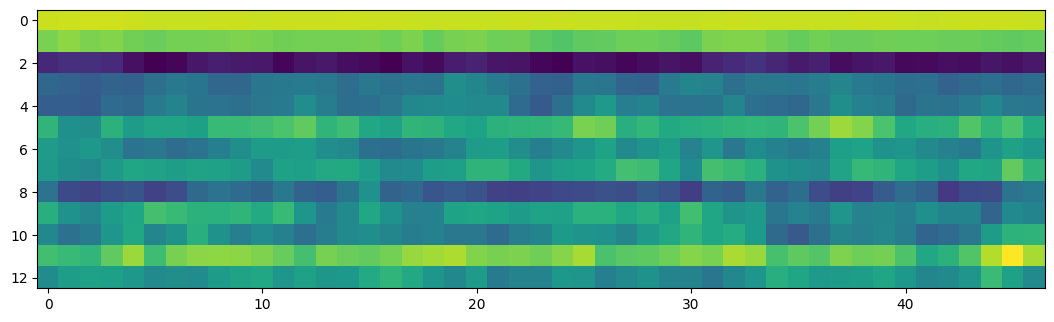

In [15]:
plt.rc('figure', figsize=(13, 4))
assert plt.imshow(next(iter(train_dataset.take(1)))['mfcc'].numpy().T)

In [16]:
train_dataset = train_dataset.map(lambda d: {'mfcc': d['mfcc'], 'logits': d['logits']})
train_dataset = train_dataset.concatenate(extra_dataset)
assert len(train_dataset) == 3152472, len(train_dataset)

In [17]:
train_batch = train_dataset.cache().shuffle(len(train_dataset))
train_batch = train_batch.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
train_batch = train_batch.map(lambda d: d.update({'mfcc': spectrogram_masking(d['mfcc'], 1)}) or d)
train_batch = train_batch.map(lambda d: d.update({'mfcc': spectrogram_masking(d['mfcc'], 2)}) or d)
valid_batch = valid_dataset.cache().batch(GLOBAL_BATCH_SIZE)
test_batch  = test_dataset.cache().batch(GLOBAL_BATCH_SIZE)

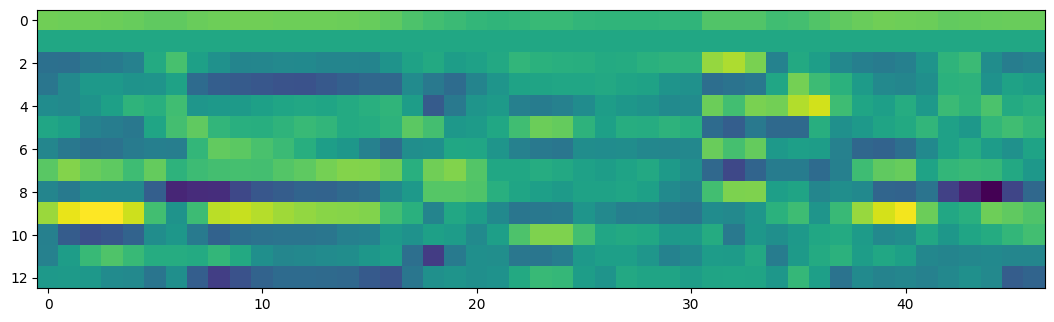

In [18]:
plt.rc('figure', figsize=(13, 4))
assert plt.imshow(next(iter(train_batch.take(1)))['mfcc'][0].numpy().T)

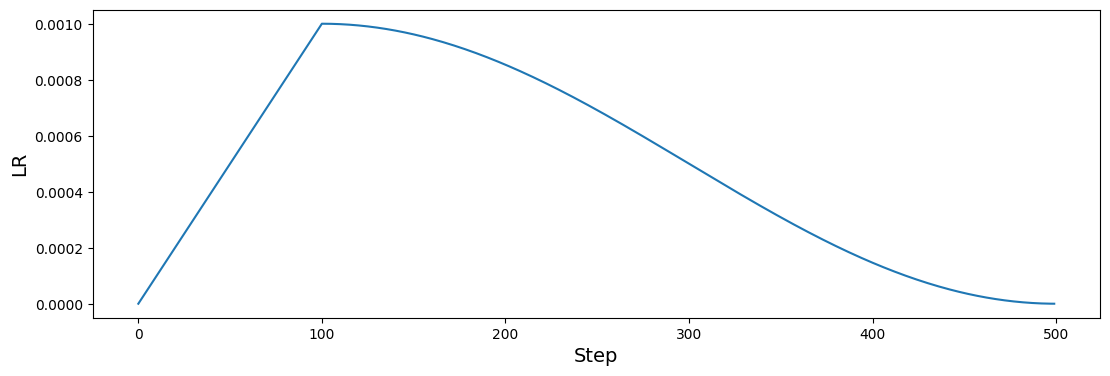

In [19]:
scheduled_lrs = WarmUpCosine(
  learning_rate_base=1e-3,
  total_steps=TOTAL_TRAINING_EPOCHS * len(train_batch),
  warmup_learning_rate=0.0,
  warmup_ratio=0.2,
)

plt.plot([scheduled_lrs(step) for step in range(0, scheduled_lrs.total_steps,
                                                len(train_batch))])
plt.xlabel("Step", fontsize=14)
assert plt.ylabel("LR", fontsize=14)

In [20]:
model_cls = build_model(num_labels=12)
model_cls.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 128)               1323136   
                                                                 
 model_1 (Functional)        (None, 12)                68620     
                                                                 
Total params: 1,391,756
Trainable params: 1,385,612
Non-trainable params: 6,144
_________________________________________________________________


In [21]:
with strategy.scope():
  tpu_model = Distiller(keras.Sequential.from_config(model_cls.get_config()))
  tpu_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=scheduled_lrs),
    metrics=[
      keras.metrics.SparseCategoricalAccuracy('acc'),
      keras.metrics.SparseTopKCategoricalAccuracy(3, 'top3')
    ],
    temperature=10,
    steps_per_execution=len(train_batch))

In [ ]:
# Distill teacher to student
history = tpu_model.fit(train_batch, validation_data=valid_batch,
                        epochs=TOTAL_TRAINING_EPOCHS, verbose=2)

model_cls.set_weights(tpu_model.student.get_weights())

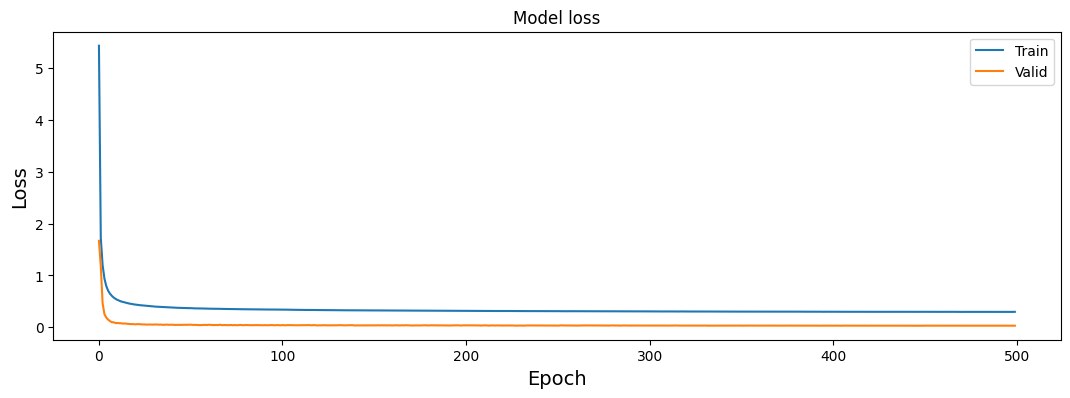

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
assert plt.legend(['Train', 'Valid'], loc='upper right')

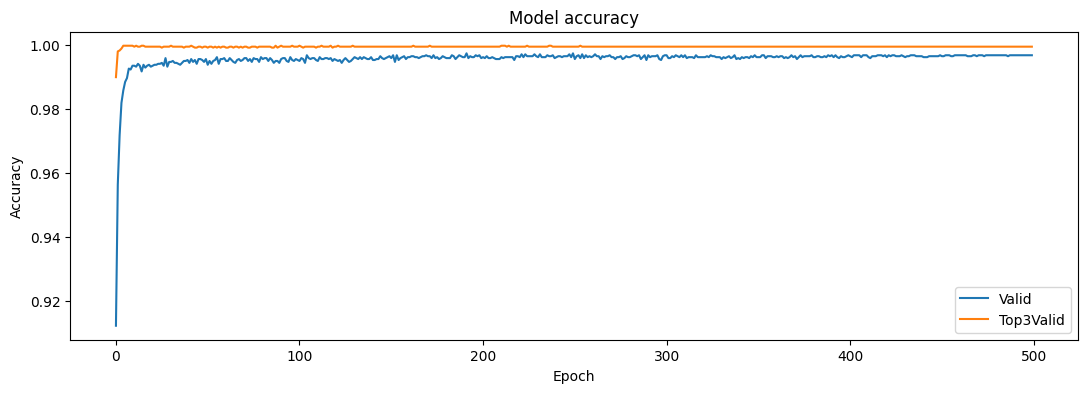

In [24]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_top3'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
assert plt.legend(['Valid', 'Top3Valid'], loc='lower right')

In [25]:
pred = model_cls.predict(test_batch.map(lambda d: d['mfcc']), verbose=0).argmax(axis=-1)
print(sum(1 for p, l in zip(pred, test_dataset) if p != l['label']), len(pred))
pred = model_cls.predict(valid_batch.map(lambda d: d['mfcc']), verbose=0).argmax(axis=-1)
print(sum(1 for p, l in zip(pred, valid_dataset) if p != l['label']), len(pred))

22 3773
12 3368


#Is Digit Mask NN

In [26]:
(extra_dataset,), info = tfds.load(
    name='my_dataset', split=['train'],
    data_dir='gs://tfds-isdigitensemble-cv12-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/digit_mask_ensemble_distilled_from_cv12_balanced_mfcc'
assert len(extra_dataset) == 10122488, len(extra_dataset)

In [27]:
(train_dataset, test_dataset, valid_dataset), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-isdigit-ensemble-ft-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/digit_mask_ft_ensemble_distilled_mfcc'
assert len(train_dataset) == 1825800, len(train_dataset)

In [28]:
# assert [0.5, 0.5001834812137146] == [
#     float(d.reduce(tf.cast(0, tf.int64), lambda x, d: x + tf.argmax(d['logits']))) / len(d)
#     for d in (extra_dataset, train_dataset)]

In [29]:
# assert [10122199, 1825796, 6086, 5276] == [
#     len(set(hash(d['mfcc'].numpy().tobytes()) for d in tqdm(i)))
#     for i in (extra_dataset, train_dataset, test_dataset, valid_dataset)]

In [30]:
print(int(test_dataset.reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(test_dataset))

5 6086


In [31]:
print(int(valid_dataset.reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(valid_dataset))

5 5276


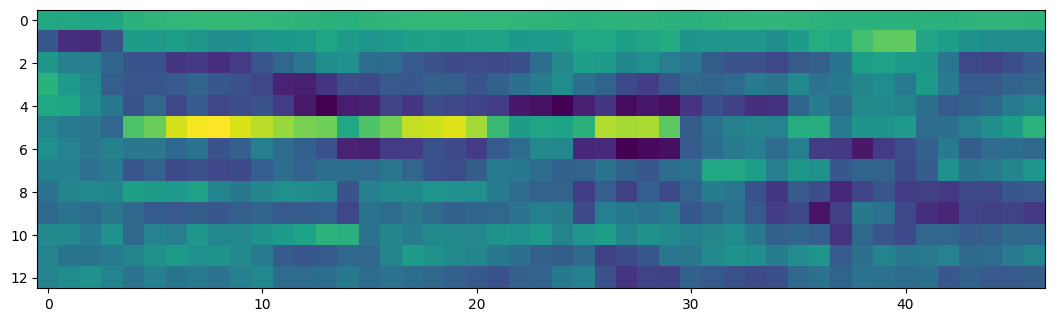

In [32]:
plt.rc('figure', figsize=(13, 4))
assert plt.imshow(next(iter(train_dataset.take(1)))['mfcc'].numpy().T)

In [33]:
train_dataset = train_dataset.map(lambda d: {'mfcc': d['mfcc'], 'logits': d['logits']})
train_dataset = train_dataset.concatenate(extra_dataset)
assert len(train_dataset) == 11948288, len(train_dataset)

In [34]:
train_batch = train_dataset.cache().shuffle(len(train_dataset))
train_batch = train_batch.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
train_batch = train_batch.map(lambda d: d.update({'mfcc': spectrogram_masking(d['mfcc'], 1)}) or d)
train_batch = train_batch.map(lambda d: d.update({'mfcc': spectrogram_masking(d['mfcc'], 2)}) or d)
valid_batch = valid_dataset.cache().batch(GLOBAL_BATCH_SIZE)
test_batch  = test_dataset.cache().batch(GLOBAL_BATCH_SIZE)

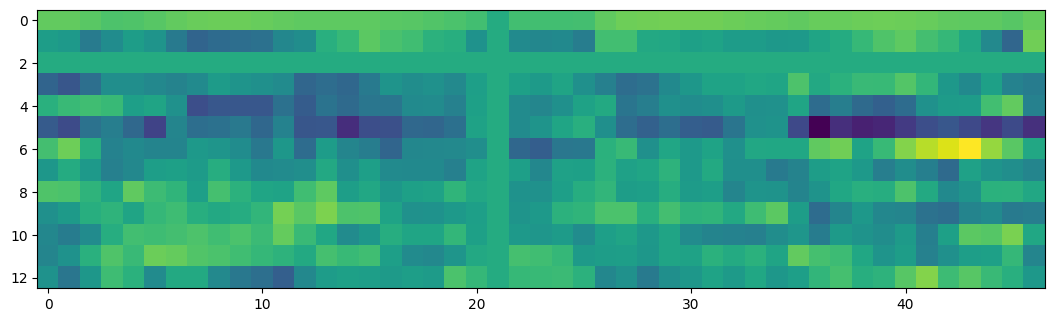

In [35]:
plt.rc('figure', figsize=(13, 4))
assert plt.imshow(next(iter(train_batch.take(1)))['mfcc'][0].numpy().T)

In [36]:
TOTAL_TRAINING_EPOCHS //= 3

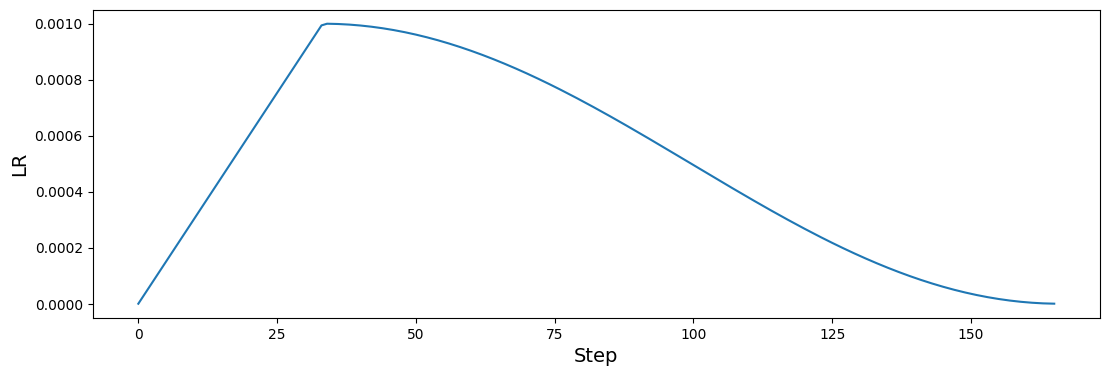

In [37]:
scheduled_lrs = WarmUpCosine(
  learning_rate_base=1e-3,
  total_steps=TOTAL_TRAINING_EPOCHS * len(train_batch),
  warmup_learning_rate=0.0,
  warmup_ratio=0.2,
)

plt.plot([scheduled_lrs(step) for step in range(0, scheduled_lrs.total_steps,
                                                len(train_batch))])
plt.xlabel("Step", fontsize=14)
assert plt.ylabel("LR", fontsize=14)

In [38]:
model_bin = build_model(num_labels=2)
model_bin.summary()

Model: "mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 128)               1323136   
                                                                 
 model_3 (Functional)        (None, 2)                 67330     
                                                                 
Total params: 1,390,466
Trainable params: 1,384,322
Non-trainable params: 6,144
_________________________________________________________________


In [39]:
with strategy.scope():
  tpu_model = Distiller(keras.Sequential.from_config(model_bin.get_config()))
  tpu_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=scheduled_lrs),
    metrics=[keras.metrics.SparseCategoricalAccuracy('acc')],
    temperature=10,
    steps_per_execution=len(train_batch))

In [ ]:
history = tpu_model.fit(train_batch, validation_data=valid_batch,
                        epochs=TOTAL_TRAINING_EPOCHS, verbose=2)

model_bin.set_weights(tpu_model.student.get_weights())

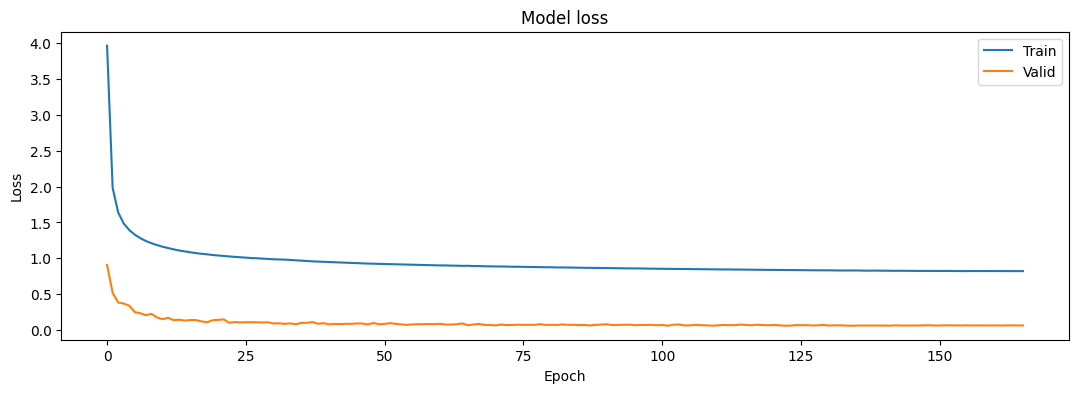

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
assert plt.legend(['Train', 'Valid'], loc='upper right')

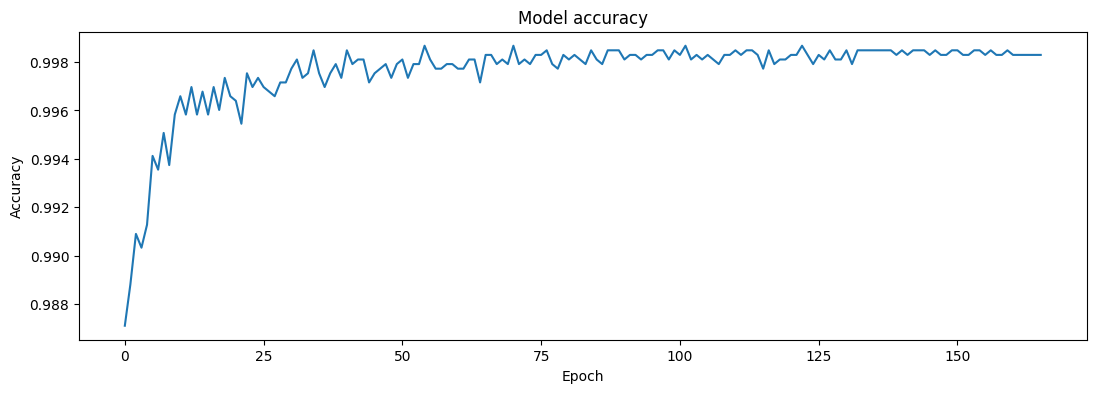

In [42]:
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
assert plt.xlabel('Epoch')

In [43]:
pred = model_bin.predict(test_batch.map(lambda d: d['mfcc']), verbose=0).argmax(axis=-1)
print(sum(1 for p, l in zip(pred, test_dataset) if l['label'] and not p),
      sum(1 for p, l in zip(pred, test_dataset) if not l['label'] and p), len(pred))
pred = model_bin.predict(valid_batch.map(lambda d: d['mfcc']), verbose=0).argmax(axis=-1)
print(sum(1 for p, l in zip(pred, valid_dataset) if l['label'] and not p),
      sum(1 for p, l in zip(pred, valid_dataset) if not l['label'] and p), len(pred))

8 8 6086
1 7 5276


# Target NN

In [44]:
def build_target_model():
  i = keras.Input(shape=model_cls.input_shape[1:])
  c = tf.math.softmax(model_cls(i))
  b = tf.math.softmax(model_bin(i))
  o = tf.concat([c[:,:10] * b[:,1:], c[:,10:]], axis=-1)
  o = tf.math.softmax(tf.math.log(o))
  return keras.Model(inputs=i, outputs=o, name='target')

In [45]:
model = build_target_model()
model.summary()

Model: "target"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 47, 13)]     0           []                               
                                                                                                  
 classifier (Sequential)        (None, 12)           1391756     ['input_5[0][0]']                
                                                                                                  
 mask (Sequential)              (None, 2)            1390466     ['input_5[0][0]']                
                                                                                                  
 tf.nn.softmax (TFOpLambda)     (None, 12)           0           ['classifier[0][0]']             
                                                                                             

In [46]:
pred = model.predict(test_batch.map(lambda d: d['mfcc']), verbose=0).argmax(axis=-1) < 10
print(sum(1 for p, l in zip(pred, test_dataset) if l['label'] and not p),
      sum(1 for p, l in zip(pred, test_dataset) if not l['label'] and p), len(pred))
pred = model.predict(valid_batch.map(lambda d: d['mfcc']), verbose=0).argmax(axis=-1) < 10
print(sum(1 for p, l in zip(pred, valid_dataset) if l['label'] and not p),
      sum(1 for p, l in zip(pred, valid_dataset) if not l['label'] and p), len(pred))

11 14 6086
8 15 5276


In [47]:
model_cls.save('model.cls.h5')
model_bin.save('model.bin.h5')
model.save('model.h5')

In [48]:
!md5sum 'model.cls.h5' 'model.bin.h5' 'model.h5'
!mv 'model.cls.h5' {TFLITE_MODEL_PATH[:-7] + '.cls.h5'}
!mv 'model.bin.h5' {TFLITE_MODEL_PATH[:-7] + '.bin.h5'}
!mv 'model.h5' {TFLITE_MODEL_PATH[:-7] + '.h5'}

a903e9d6aea98b4096861b5c636c9929  model.cls.h5
ef6942b26af57e92a5983fb8b45fcc14  model.bin.h5
0baa574b5ea4470e3ca3da79a915e94e  model.h5


In [49]:
with open('model.tflite', 'wb') as f:
  f.write(tf.lite.TFLiteConverter.from_keras_model(model).convert())

In [50]:
!md5sum 'model.tflite'
!mv 'model.tflite' "$TFLITE_MODEL_PATH"

7177cfe474d50bc4900bae2a97d9d093  model.tflite
